In [1]:
%cd ../src/

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy
import torch

from concepts import concept_instances
from probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
game_data = load_game_data()
q_network, device = load_q_network_device()
q_network.to('cpu')

layer = '5'
hyperparams = {
    'lr': 0.0005,
    'batch_size': 64,
    'epochs': 200,
    'lambda_l1': 0.00001,
    'patience': 5
}

actions = ['None', 'Fire', 'Right', 'Left']

In [4]:
# is gradient correct terminology, should it be directional derivative right?
concept_mean_max_gradient = {} # does adding a concept improve max(q value)?
concept_action_mean_gradient = {a:[] for a in actions} # does adding a concept improve mean(q value)?
concept_q_improvement = {} # does concept improve max(q value)?
concept_action_max_gradient = {a:[] for a in actions} # how often did this action have the highest gradient?
concept_cavs = {} # save probe for each concept

In [5]:
q_network

QNetwork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [6]:
# find layer as idx to skip to this part of the network
for idx, (name, l) in enumerate(q_network.network.named_children()):
    if name == layer:
        break

In [7]:
for concept in concept_instances.values():
    # train probe
    probe, score = train_probe(game_data, q_network, concept, layer, hyperparams)
    print(f'{concept.name}: {score}')
    # get q values and test activations
    q_values, acts_dict = q_network(torch.tensor(concept.test_obs), return_acts=True)
    acts = acts_dict[layer]

    # extract cav from probe and reshape
    cav = probe[1].weight
    concept_cavs[concept.name] = cav
    acts.requires_grad_(True)

    # Forward pass
    q_values = q_network.network[idx + 1:](acts)

    # Flatten the activations and CAV
    acts_flat = acts.view(acts.shape[0], -1)
    cav_flat = cav.view(-1)
    cav_flat = cav_flat / torch.norm(cav_flat)

    # Normalize the CAV
    cav_norm = cav_flat / torch.norm(cav_flat)

    # Initialize tensor to store results
    directional_derivatives = torch.zeros_like(q_values)

    # Compute directional derivatives
    for j in range(q_values.shape[1]):
        q_values[:, j].backward(torch.ones_like(q_values[:, j]), retain_graph=True)
        
        # Calculate directional derivative
        grads_flat = acts.grad.view(acts.shape[0], -1)
        directional_derivatives[:, j] = torch.mv(grads_flat, cav_norm)
        
        # Zero out gradients for the next iteration
        acts.grad.zero_()

    # calculate mean max (as in the best action) directional derivative
    concept_mean_max_gradient[concept.name] = torch.mean(torch.max(directional_derivatives, dim=1)[0]).item()

    mean_action_derivatives = torch.mean(directional_derivatives, dim=0).tolist()
    # calculate mean directional derivative for each concept
    for i, mdd in enumerate(mean_action_derivatives):
        concept_action_mean_gradient[actions[i]].append(mdd)

    # count how often max derivative is positive
    concept_q_improvement[concept.name] = torch.sum(torch.max(directional_derivatives, dim=1)[0] > 0).item() / directional_derivatives.shape[0]

    # count which action has the highest derivative
    max_action = torch.argmax(directional_derivatives, dim=1)
    most_improvement_counter = {i: sum(max_action == i) / directional_derivatives.shape[0] for i in range(len(actions))}
    for i, action in enumerate(actions):
        action_name = actions[i]
        concept_action_max_gradient[action_name].append(most_improvement_counter[i].item())


random (b): 0.053819442788759865
all lives (b): 1.0
last life (b): 0.9895833333333334
reward (b): 0.8589285612106323
ball collision (b): 0.7966852250852083
ball low (b): 0.9588815789473685
ball left paddle (b): 0.8276041686534882
ball right paddle (b): 0.8058344878648457
ball same x paddle (b): 0.5703125
ball distance paddle: 0.9086815516153971
ball y: 0.9009471038977305
ball y next: 0.9009256785114607
ball x: 0.9332763502995173
ball x next: 0.9168970510363579
lives: 0.9945229391256968
x diff: 0.7213551700115204
frames until collision horizontal: 0.3429172510902087
frames until collision vertical: 0.38818136354287464
paddle x: 0.9601869160930315
ball speed horizontal: 0.669184443851312
ball speed vertical: 0.6242265601952871
game steps: 0.9953566392262777
bricks hit: 0.9967966601252556


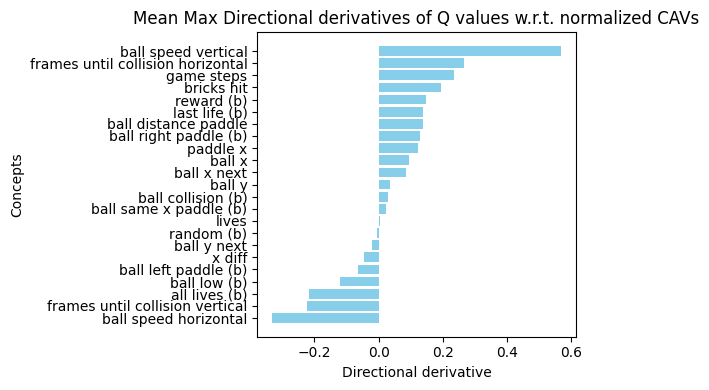

In [8]:
sorted_data = sorted(concept_mean_max_gradient.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Directional derivative')
plt.ylabel('Concepts')
plt.title('Mean Max Directional derivatives of Q values w.r.t. normalized CAVs')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

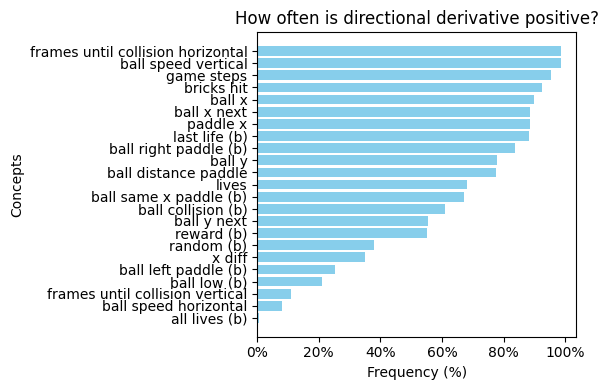

In [9]:
sorted_data = sorted(concept_q_improvement.items(), key=lambda x: x[1], reverse=True)
# Extracting keys and values, and converting values to percentages
keys = [item[0] for item in sorted_data]
values = [item[1] * 100 for item in sorted_data]

# Creating the bar chart
plt.figure(figsize=(6, 4))
plt.barh(keys, values, color='skyblue')
plt.xlabel('Frequency (%)')
plt.ylabel('Concepts')
plt.title('How often is directional derivative positive?')
plt.gca().invert_yaxis()  # To display the largest values at the top
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
plt.gca().xaxis.set_ticks(range(0, 101, 20))
plt.tight_layout()
plt.show()

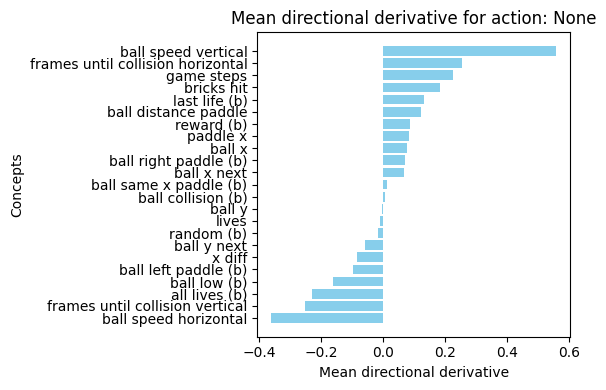

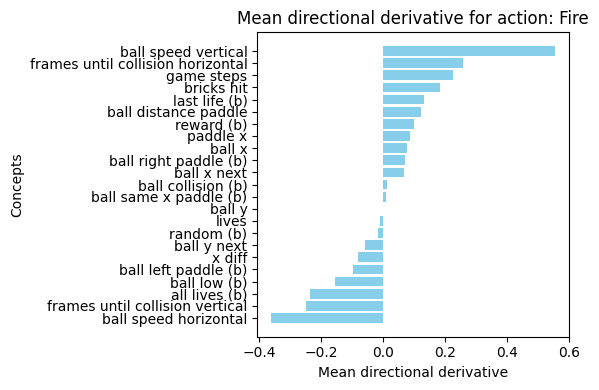

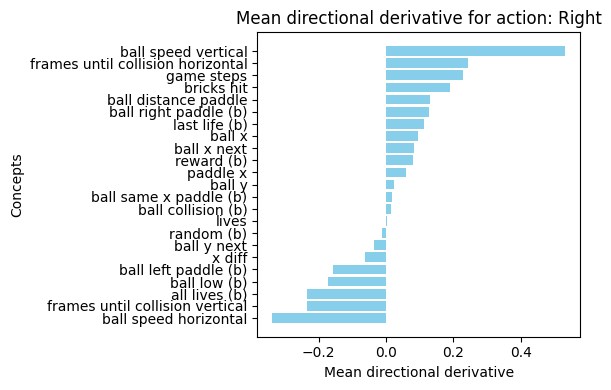

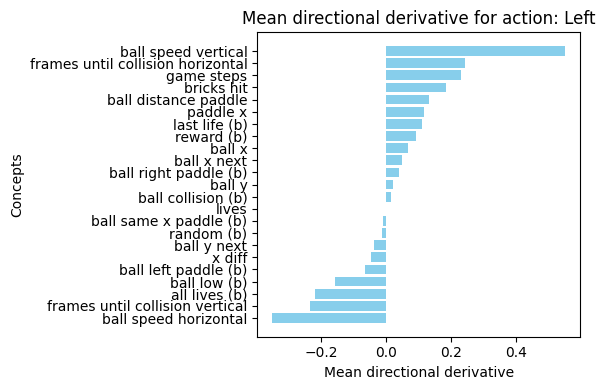

In [10]:
concept_names = list(concept_instances.keys())
for action_name, values in concept_action_mean_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i] for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Mean directional derivative')
    plt.ylabel('Concepts')
    plt.title(f'Mean directional derivative for action: {action_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

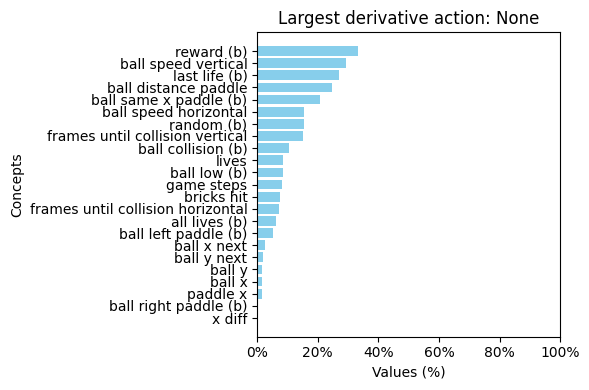

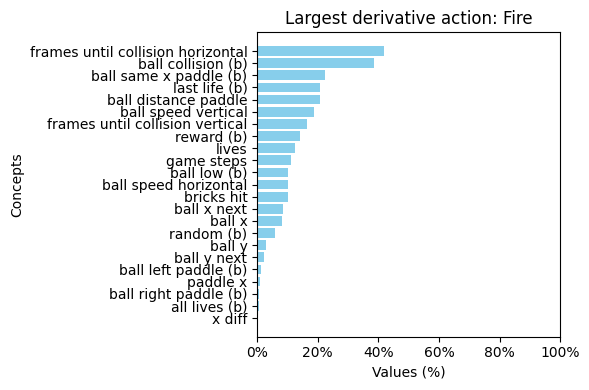

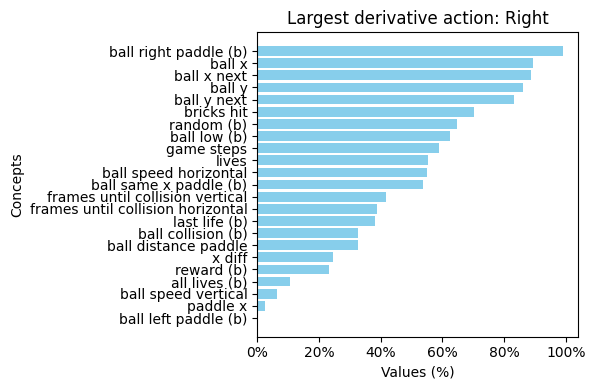

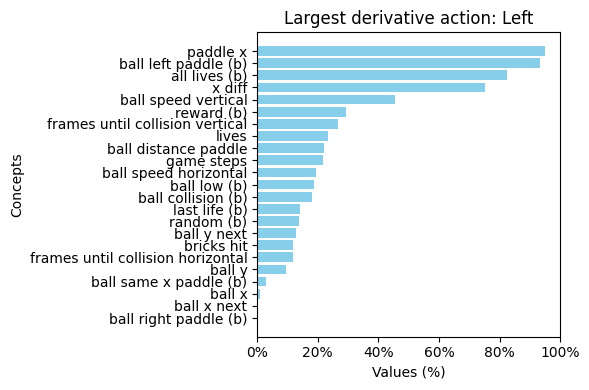

In [11]:
for action_name, values in concept_action_max_gradient.items():
    # Sort values and concept_names together in descending order
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    sorted_values = [values[i]*100 for i in sorted_indices]
    sorted_concept_names = [concept_names[i] for i in sorted_indices]
    
    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(sorted_concept_names, sorted_values, color='skyblue')
    plt.xlabel('Values (%)')
    plt.ylabel('Concepts')
    plt.title(f'Largest derivative action: {action_name}')
    plt.gca().invert_yaxis()
    plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    plt.gca().xaxis.set_ticks(range(0, 101, 20))
    plt.tight_layout()
    plt.show()